# Uso de AutoCodificadores imagenes - reducción de dimensiones

## Los Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

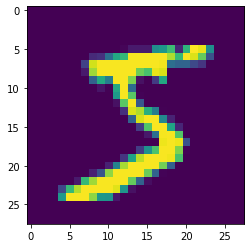

In [4]:
plt.imshow(X_entreno[0])

Se normalizan los datos (escala original 0 - 255)

In [5]:
X_entreno = X_entreno/255
X_prueba = X_prueba/255

## AutoCodificador Básico

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.optimizers import SGD

Es buena idea armar lo que se llama un "AutoCodificador Apilado" en el cual cada capa va rebajando el número de neuronas hasta el número que desee. 

Esto es principalmente para que el aprendizaje pueda ser más escalonado y no intentar que sea de un solo golpe.

Para este ejercicio se irá bajando aproximadamente de mitad en mitad, hasta llegar a una capa de tan solo 25 neuronas.

Esto es totalmente arbirtrario y pueden escogerse otros esquémas

In [7]:
784/2

392.0

In [8]:
codificador = Sequential()
codificador.add(Flatten(input_shape = [28, 28]))
codificador.add(Dense(400, activation = "relu"))
codificador.add(Dense(200, activation = "relu"))
codificador.add(Dense(100, activation = "relu"))
codificador.add(Dense(50, activation = "relu"))
codificador.add(Dense(25, activation = "relu"))

2022-09-17 18:50:48.042662: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 18:50:48.045254: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


La capa final de codificador es de 25 unidades,  El decodificador toma esa como entrada y va aumentando hasta llegar a la dimensión correcta.

Como se desea comparar con la imagen original, es necesario cambiar al formato original de 28 X 28

In [10]:
decodificador = Sequential()
decodificador.add(Dense(50, input_shape = [25],
                        activation = 'relu'))
decodificador.add(Dense(100, activation = 'relu'))
decodificador.add(Dense(200, activation = 'relu'))
decodificador.add(Dense(400, activation = 'relu'))
decodificador.add(Dense(784, activation = "sigmoid"))
decodificador.add(Reshape([28, 28]))

### Conformar el autocodificador completo.

Se utiliza la función de activación *sigmoid* porque usaremos la función de pérdida *binary_crossenthropy*

Se utilza la función de pérdida *binary_crossenthropy* porque no interesa obtener clases sino conocer si la imagen resultante es similar a la original.

In [11]:
autocodificador = Sequential([codificador, 
                              decodificador])
autocodificador.compile(loss="binary_crossentropy",optimizer=SGD(lr=1.5),metrics=['accuracy'])

In [12]:
autocodificador.fit(X_entreno, X_entreno, 
                    epochs = 5,
                    validation_data=[X_prueba, 
                                     X_prueba])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 32s 541us/sample - loss: 0.2508 - accuracy: 0.7916 - val_loss: 0.2017 - val_accuracy: 0.7931
Epoch 2/5
60000/60000 [==============================] - 33s 543us/sample - loss: 0.1781 - accuracy: 0.7988 - val_loss: 0.1596 - val_accuracy: 0.8016
Epoch 3/5
60000/60000 [==============================] - 34s 563us/sample - loss: 0.1545 - accuracy: 0.8031 - val_loss: 0.1445 - val_accuracy: 0.8033
Epoch 4/5
60000/60000 [==============================] - 36s 596us/sample - loss: 0.1438 - accuracy: 0.8051 - val_loss: 0.1392 - val_accuracy: 0.8057
Epoch 5/5
60000/60000 [==============================] - 34s 566us/sample - loss: 0.1368 - accuracy: 0.8064 - val_loss: 0.1341 - val_accuracy: 0.8078


Ahora veamos si el autocodificador puede predecir (en este caso, reconstruir) las imágenes que le pasamos

In [13]:
imagenes_pasadas = autocodificador.predict(X_prueba[:10])

Imagen original


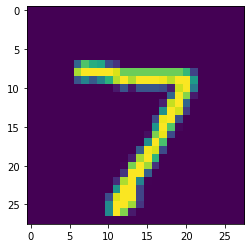

Imagen reconstruida con el autocodificador


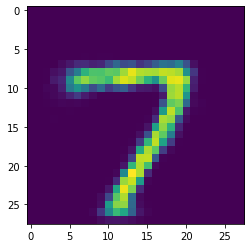

In [26]:
n = 0   # Seleccionar la imagen que se desea comparar

print("Imagen original")
plt.imshow(X_prueba[n]);
plt.show()
print("Imagen reconstruida con el autocodificador")
plt.imshow(imagenes_pasadas[n]);

Probemos con otra imagen...ejecutar celda anterior con otro valor de n.

Bastante impresionante...se redujeron las dimensiones de 28X28 = 784 a tan solo 25, o sea solo el 3% de las dimensiones originales, y se lograron imágenes bastante parecidas!

# AutoCodificadores para reducir el ruido en imágenes

In [30]:
from tensorflow.keras.layers import GaussianNoise

Veámos cómo funciona el generador de ruido

In [31]:
muestra = GaussianNoise(0.2)   # Desviación estándard, si se quiere más ruido, incrementar

In [32]:
ruidosas = muestra(X_prueba[:10], training = True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Imagen original


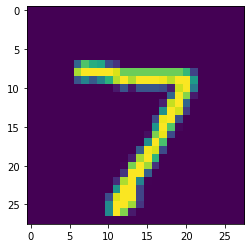

Imagen ruidosa


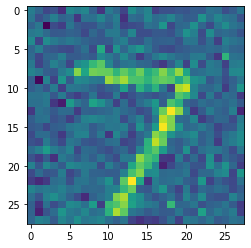

In [33]:
n = 0   # Seleccionar la imagen que se desea comparar

print("Imagen original")
plt.imshow(X_prueba[n]);
plt.show()
print("Imagen ruidosa")
plt.imshow(ruidosas[n]);

Veamos otra...otro valor de n

### Crear autocodificador para eliminación de ruido y entrenarlo.

In [34]:
import tensorflow as tf
import numpy as np

La siguiente celda es opcional, se usa para tener reproducibilidad

In [35]:
tf.random.set_seed(101)
np.random.seed(101)

Vamos a usar el mismo autocodificador, solo que le agregaremos una capa, para introducir el ruido a las imágenes,  el codificador

In [36]:
codificador = Sequential()
codificador.add(Flatten(input_shape = [28, 28]))
# Agregar ruido a las imágenes antes de pasarlas por el autocodificador
codificador.add(GaussianNoise(0.2))
codificador.add(Dense(400, activation = "relu"))
codificador.add(Dense(200, activation = "relu"))
codificador.add(Dense(100, activation = "relu"))
codificador.add(Dense(50, activation = "relu"))
codificador.add(Dense(25, activation = "relu"))

In [37]:
decodificador = Sequential()
decodificador.add(Dense(50, input_shape = [25],
                        activation = 'relu'))
decodificador.add(Dense(100, activation = 'relu'))
decodificador.add(Dense(200, activation = 'relu'))
decodificador.add(Dense(400, activation = 'relu'))
decodificador.add(Dense(784, activation = "sigmoid"))
decodificador.add(Reshape([28, 28]))

In [38]:
eliminador_ruido = Sequential([codificador, 
                               decodificador])

In [39]:
eliminador_ruido.compile(loss = "binary_crossentropy", 
                         optimizer = 'adam', 
                         metrics =['accuracy'])

In [40]:
eliminador_ruido.fit(X_entreno, X_entreno, 
                     epochs = 8,
                     validation_data=[X_prueba, X_prueba])

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1710 - accuracy: 0.8011 - val_loss: 0.1339 - val_accuracy: 0.8053
Epoch 2/8
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.1313 - accuracy: 0.8077 - val_loss: 0.1226 - val_accuracy: 0.8084
Epoch 3/8
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.1219 - accuracy: 0.8094 - val_loss: 0.1144 - val_accuracy: 0.8101
Epoch 4/8
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.1161 - accuracy: 0.8104 - val_loss: 0.1115 - val_accuracy: 0.8100
Epoch 5/8
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.1131 - accuracy: 0.8109 - val_loss: 0.1086 - val_accuracy: 0.8105
Epoch 6/8
60000/60000 [==============================] - 60s 998us/sample - loss: 0.1107 - accuracy: 0.8112 - val_loss: 0.1071 - val_accuracy: 0.8109
Epoch 7/8
60000/60000 [==============================] - 68s

In [41]:
diez_imags_con_ruido = muestra(X_prueba[: 10], 
                                 training = True)
limpias = eliminador_ruido(diez_imags_con_ruido[: 10])

OJO!!!  Nótese que en la celda anterior, realmente hemos "duplicado" la cantidad de ruido:  una vez por generar imágenes con ruido (primera instrucción), y una segunda vez por pasarlo por el codificador! 

La Original


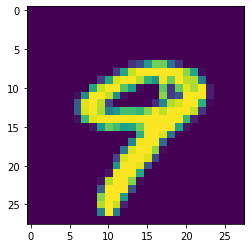

La version con ruido


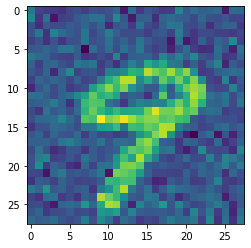

Luego de pasar por el eliminidador de ruido


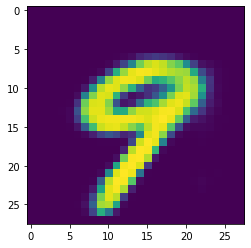

In [43]:
n = 9
print("La Original")
plt.imshow(X_prueba[n])
plt.show()
print("La version con ruido")
plt.imshow(diez_imags_con_ruido[n])
plt.show()
print("Luego de pasar por el eliminidador de ruido")
plt.imshow(limpias[n])
plt.show()